**Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import SimpleImputer

# from keras.models import Model
# from keras. layers import Dense
# from keras. layers import Input

**Mounting files from google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Colab Notebooks/Network anomaly/UNSW_NB15_training-set.csv'
file_path2 = '/content/drive/My Drive/Colab Notebooks/Network anomaly/UNSW_NB15_testing-set.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




```
# Bu, kod olarak biçimlendirilmiştir
```

**Loading dataset**

In [29]:
train_set = pd.read_csv(file_path)
test_set = pd.read_csv(file_path2)


In [4]:
train_set['proto'] = train_set['proto'].apply(lambda x: x if x in ['tcp', 'udp', 'arp'] else 'others')
test_set['proto'] = test_set['proto'].apply(lambda x: x if x in ['tcp', 'udp', 'arp'] else 'others')
#train_set['proto'].value_counts()
test_set['proto'].value_counts()

,count
proto,
tcp,79951
udp,63283
others,29253
arp,2859


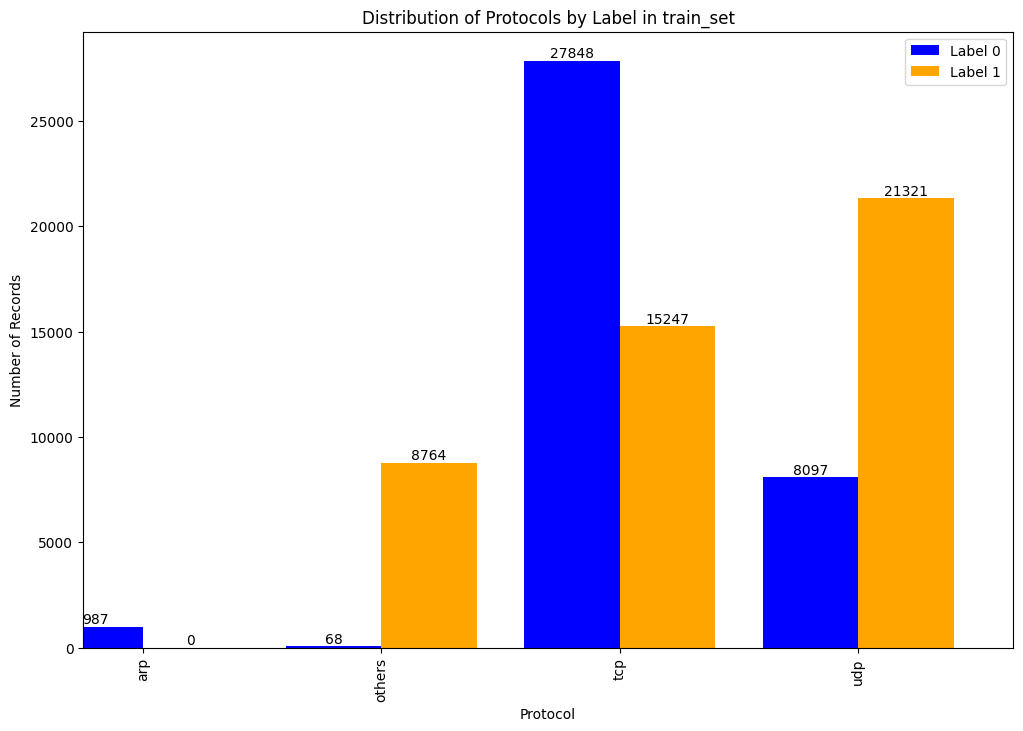

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each protocol by label (0 and 1)
protocol_label_counts = train_set.groupby(['proto', 'label']).size().unstack(fill_value=0)

# Plotting the grouped bar chart
plt.figure(figsize=(12, 8))

# Plot bars for label 0 (blue)
ax = protocol_label_counts[0].plot(kind='bar', width=0.4, position=1, color='blue', label='Label 0', ax=plt.gca())

# Plot bars for label 1 (orange)
protocol_label_counts[1].plot(kind='bar', width=0.4, position=0, color='orange', label='Label 1', ax=plt.gca())

# Title and labels
plt.title('Distribution of Protocols by Label in train_set')
plt.xlabel('Protocol')
plt.ylabel('Number of Records')
plt.xticks(rotation=90)  # Rotate labels for better visibility

# Adding a legend
plt.legend()

# Annotate each bar with its height (the value)
for i, protocol in enumerate(protocol_label_counts.index):
    # Annotate label 0 bars (blue)
    ax.text(i - 0.2, protocol_label_counts.iloc[i, 0] + 10, str(protocol_label_counts.iloc[i, 0]),
            ha='center', va='bottom', fontsize=10, color='black')

    # Annotate label 1 bars (orange)
    ax.text(i + 0.2, protocol_label_counts.iloc[i, 1] + 10, str(protocol_label_counts.iloc[i, 1]),
            ha='center', va='bottom', fontsize=10, color='black')

plt.show()


Features which will not be scaled (id and attack_cat are not needed ; others are categorical and last 2 is binary)

In [ ]:
categorical_cols =['id','proto', 'service', 'state', 'attack_cat', 'label']

In [30]:
categorical_cols =['id','proto', 'service', 'state', 'attack_cat', 'label','is_sm_ips_ports', 'is_ftp_login']

In [31]:
test_set = test_set[
    ~(
        #test_set['proto'].isin(['icmp', 'rtp']) |
        test_set['state'].isin(['URN', 'ECO', 'no', 'PAR'])
    )
]


In [7]:
# For train_set
print("Train Set Unique Values:")
for col in ['proto', 'service', 'state']:
    print(f"{col} (train):", sorted(train_set[col].unique()))

print("\nTest Set Unique Values:")
# For test_set
for col in ['proto', 'service', 'state']:
    print(f"{col} (test):", sorted(test_set[col].unique()))


#['icmp', 'rtp'] proto field test set de var train'de yoxdu  icmp 15 (0 attack)  rtp 1 (0 attack)
#service is same
#{'URN', 'ECO', 'no', 'PAR'} for state    URN 1 (0 attack) ; ECO 12(0 attack) ; no 1 (0); PAR 1 (0 attack)
#train_set['ACC'] = 4 and 2 attacks ;  train_set['state'] == 'CLO' 1 and 1 attack;

Train Set Unique Values:
proto (train): ['arp', 'others', 'tcp', 'udp']
service (train): ['-', 'dhcp', 'dns', 'ftp', 'ftp-data', 'http', 'irc', 'pop3', 'radius', 'smtp', 'snmp', 'ssh', 'ssl']
state (train): ['ACC', 'CLO', 'CON', 'FIN', 'INT', 'REQ', 'RST']

Test Set Unique Values:
proto (test): ['arp', 'others', 'tcp', 'udp']
service (test): ['-', 'dhcp', 'dns', 'ftp', 'ftp-data', 'http', 'irc', 'pop3', 'radius', 'smtp', 'snmp', 'ssh', 'ssl']
state (test): ['ACC', 'CLO', 'CON', 'FIN', 'INT', 'REQ', 'RST']


**StandardScaler**

In [8]:
from sklearn.preprocessing import StandardScaler

def scale_data_keep_categorical(train_df, test_df, target_col='label', categorical_cols=[]):
    # Save labels
    train_labels = train_df[target_col].astype(int)
    test_labels = test_df[target_col].astype(int)

    # Drop label and categorical columns to scale only numerical ones
    train_numerical = train_df.drop(categorical_cols , axis=1)
    test_numerical = test_df.drop(categorical_cols , axis=1)

    # Scale numerical featuresS
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_numerical)
    test_scaled = scaler.transform(test_numerical)

    # Convert scaled data back to DataFrames
    train_scaled_df = pd.DataFrame(train_scaled, columns=train_numerical.columns)
    test_scaled_df = pd.DataFrame(test_scaled, columns=test_numerical.columns)

    # Reattach categorical columns and label
    train_final = pd.concat([train_scaled_df, train_df[categorical_cols].reset_index(drop=True)], axis=1)
    test_final = pd.concat([test_scaled_df, test_df[categorical_cols].reset_index(drop=True)], axis=1)

    train_final[target_col] = train_labels.values
    test_final[target_col] = test_labels.values

    return train_final, test_final




**Robust scaling**

In [ ]:
from sklearn.preprocessing import RobustScaler

def scale_data_keep_categorical(train_df, test_df, target_col='label', categorical_cols=[]):
    # Save labels
    train_labels = train_df[target_col].astype(int)
    test_labels = test_df[target_col].astype(int)

    # Drop label and categorical columns to scale only numerical ones
    train_numerical = train_df.drop(categorical_cols + [target_col], axis=1)
    test_numerical = test_df.drop(categorical_cols + [target_col], axis=1)

    # Scale numerical features using RobustScaler
    scaler = RobustScaler()
    train_scaled = scaler.fit_transform(train_numerical)
    test_scaled = scaler.transform(test_numerical)

    # Convert scaled data back to DataFrames
    train_scaled_df = pd.DataFrame(train_scaled, columns=train_numerical.columns)
    test_scaled_df = pd.DataFrame(test_scaled, columns=test_numerical.columns)

    # Reattach categorical columns and label
    train_final = pd.concat([train_scaled_df, train_df[categorical_cols].reset_index(drop=True)], axis=1)
    test_final = pd.concat([test_scaled_df, test_df[categorical_cols].reset_index(drop=True)], axis=1)

    train_final[target_col] = train_labels.values
    test_final[target_col] = test_labels.values

    return train_final, test_final


In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#print(train_set.head(2))

**Checking our dataset for any missing values**

In [10]:
print("Total missing values in train_set:", train_set.isnull().sum().sum())
print("Total missing values in test_set:", test_set.isnull().sum().sum())



Total missing values in train_set: 0
Total missing values in test_set: 0


**Scaling our data**

In [11]:
train_scaled, test_scaled = scale_data_keep_categorical(train_set, test_set, target_col='label', categorical_cols=categorical_cols)


**One-hot encoding**

In [12]:
# Choose the categorical columns to encode
categorical_cols = ['proto', 'service', 'state']  #encoding only needed columns (label for output and attack_cat is not needed)

# Concatenate train and test to ensure consistent encoding
combined = pd.concat([train_scaled, test_scaled], keys=['train', 'test'])

# One-hot encode
combined_encoded = pd.get_dummies(combined, columns=categorical_cols)

# Split back into train and test
train_set_encoded = combined_encoded.xs('train')
test_set_encoded = combined_encoded.xs('test')


**Type 2 one hot encoding**

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

categorical_cols = ['proto', 'service', 'state']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # ✅ use sparse_output here

encoder.fit(train_set[categorical_cols])

train_encoded = encoder.transform(train_set[categorical_cols])
test_encoded = encoder.transform(test_set[categorical_cols])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=train_set.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=test_set.index)

train_set_encoded = train_set.drop(columns=categorical_cols).join(train_encoded_df)
test_set_encoded = test_set.drop(columns=categorical_cols).join(test_encoded_df)


Checking encoding if both datasets have same features

In [13]:
# Counting columns for train_set_encoded
num_columns_train = train_set_encoded.shape[1]
print("Number of columns in train_set_encoded:", num_columns_train)

# Counting columns for test_set_encoded
num_columns_test = test_set_encoded.shape[1]
print("Number of columns in test_set_encoded:", num_columns_test)



Number of columns in train_set_encoded: 66
Number of columns in test_set_encoded: 66


**Without dropping highly correlated features**

In [11]:
X = train_set_encoded.drop(columns=['id','label', 'attack_cat',])  # Drop the target column from features
y = train_set_encoded['label']  # Target variable
X_test_selected = test_set_encoded.drop(columns=['id','label', 'attack_cat']) #Test dataset
y_test = test_set_encoded['label']  # Test dataset

**After dropping highly correlated features**

In [19]:
X = train_set_encoded.drop(columns=['id', 'label', 'attack_cat', 'proto_tcp', 'dwin', 'dloss', 'dbytes', 'ct_ftp_cmd', 'ct_srv_src', 'ct_dst_src_ltm', 'sloss', 'ct_dst_ltm', 'ct_src_ltm', 'is_sm_ips_ports', 'tcprtt'])
  # Drop the target column from features
y = train_set_encoded['label']  # Target variable
X_test_selected = test_set_encoded.drop(columns=['id','label', 'attack_cat']) #Test dataset
y_test = test_set_encoded['label']  # Test dataset

**For pca**

In [ ]:
X = train_set_encoded.drop(columns=['id', 'label', 'attack_cat', 'proto_tcp', 'dwin', 'dloss', 'dbytes', 'ct_ftp_cmd', 'ct_srv_src', 'ct_dst_src_ltm', 'sloss', 'ct_dst_ltm', 'ct_src_ltm', 'is_sm_ips_ports', 'tcprtt'])
  # Drop the target column from features
y = train_set_encoded['label']  # Target variable
X_test_selected = test_set_encoded.drop(columns=['id','label', 'attack_cat','proto_tcp', 'dwin', 'dloss', 'dbytes', 'ct_ftp_cmd', 'ct_srv_src', 'ct_dst_src_ltm', 'sloss', 'ct_dst_ltm', 'ct_src_ltm', 'is_sm_ips_ports', 'tcprtt']) #Test dataset
y_test = test_set_encoded['label']  # Test dataset

**Mutual info feauture selection**

Regression mutual info

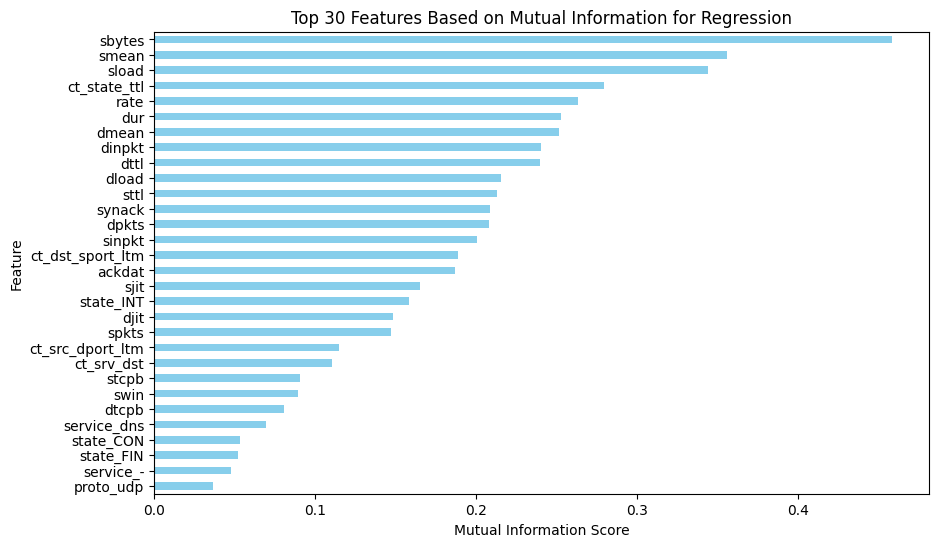

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have 'train_set_encoded' as your data and 'target' is your target column


# Apply Mutual Information for Regression (assuming continuous target)
mi_selector = SelectKBest(mutual_info_regression, k='all')
mi_selector.fit(X, y)

# Get the scores
mi_scores = pd.Series(mi_selector.scores_, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Get the top 30 features
top_30_features = mi_scores.head(30)

# Plotting the top 30 features
plt.figure(figsize=(10, 6))
top_30_features.plot(kind='barh', color='skyblue')
plt.title('Top 30 Features Based on Mutual Information for Regression')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to display top features at the top
plt.show()


classify mutual info

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Use mutual information for classification
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
X_selected = mi_selector.fit_transform(X, y)

# Get feature names of selected features
selected_features = X.columns[mi_selector.get_support()]






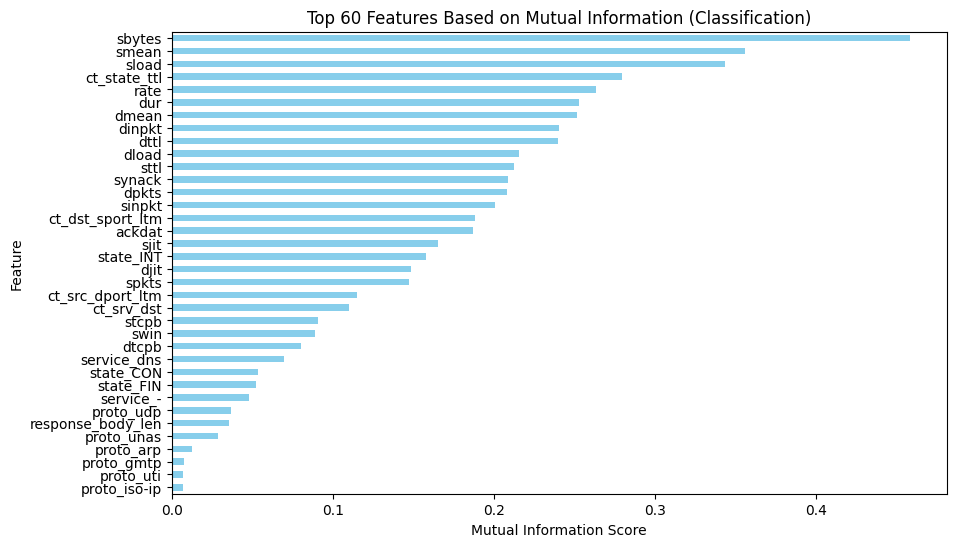

In [ ]:
# Optional: Visualize top 60 features
mi_scores = pd.Series(mi_selector.scores_, index=X.columns).sort_values(ascending=False)
top_30 = mi_scores.head(36)
plt.figure(figsize=(10, 6))
top_30.plot(kind='barh', color='skyblue')
plt.title('Top 60 Features Based on Mutual Information (Classification)')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

Selecting top 30 feautures

In [ ]:
# Step 1: Select top features
top_features = mi_scores.head(33).index.tolist()


X_train_selected = X[top_features]
X_test_selected = X_test_selected[top_features]



***L1 regularization ***

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

X_train_selected = X
y_train = y

# Apply L1 regularization (Lasso) to the training data
lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lasso.fit(X_train_selected, y_train)

# Use SelectFromModel to select important features based on L1 regularization
selector = SelectFromModel(lasso, threshold="mean", max_features=30)  # You can adjust the threshold and max_features
selector.fit(X_train_selected, y_train)

# Get the selected features
selected_features_lasso = X_train_selected.columns[selector.get_support()]
print("Selected Features using L1 Regularization (Lasso):")
print(selected_features_lasso)

# Apply the selected features to both the training and test sets
X_train_selected_lasso = X_train_selected[selected_features_lasso]
X_test_selected_lasso = X_test_selected[selected_features_lasso]


#ct_state_ttl', 'ct_dst_sport_ltm', 'ct_srv_dstS


Selected Features using L1 Regularization (Lasso):
Index(['spkts', 'sbytes', 'dttl', 'dload', 'swin', 'synack', 'dmean',
       'ct_state_ttl', 'ct_dst_sport_ltm', 'ct_srv_dst', 'proto_arp',
       'proto_igmp', 'proto_sctp', 'proto_udp', 'proto_unas', 'service_-',
       'service_dns', 'service_ftp', 'service_ftp-data', 'service_http',
       'service_radius', 'service_smtp', 'state_CON', 'state_REQ'],
      dtype='object')


L1 using classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

X_train_selected = X
y_train = y

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_selected, y_train)

# Use SelectFromModel to select features based on feature importance
selector = SelectFromModel(rf, threshold="mean", max_features=25, prefit=True)  # Adjust threshold or max_features if needed

# Get the selected features
selected_features_rf = X_train_selected.columns[selector.get_support()]
print("Selected Features using Random Forest:")
print(selected_features_rf)

# Apply the selected features to both the training and test sets
X_train_selected_lasso = X_train_selected[selected_features_rf]
X_test_selected_lasso = X_test_selected[selected_features_rf]


Selected Features using Random Forest:
Index(['dur', 'spkts', 'dpkts', 'sbytes', 'rate', 'sttl', 'dttl', 'sload',
       'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'dtcpb', 'synack',
       'ackdat', 'smean', 'dmean', 'ct_state_ttl', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_srv_dst', 'service_-', 'state_INT'],
      dtype='object')


**PCA**

In [ ]:
# Step 2: Apply PCA
pca = PCA(n_components=40)  # This retains 95% of the variance. You can adjust this based on your needs.
X_train_pca = pca.fit_transform(X)  # Fit and transform the training data
X_test_pca = pca.transform(X_test_selected)  # Transform the test data based on the PCA fit from the train data

# Step 3: Print the explained variance ratio (the amount of variance captured by each principal component)
print("Explained variance ratio by each principal component:")
print(pca.explained_variance_ratio_)

# Print the total variance explained by the components (this tells us how much information is retained)
print(f"Total variance explained by the selected principal components: {sum(pca.explained_variance_ratio_):.2f}")

# Print top contributing features for each principal component
import numpy as np
import pandas as pd

components = pd.DataFrame(np.abs(pca.components_), columns=X.columns)
print("\nTop contributing features for each principal component:")
for i in range(pca.n_components):
    top_feature = components.iloc[i].idxmax()
    print(f"PC{i+1}: {top_feature}")


Explained variance ratio by each principal component:
[0.2327007  0.08999335 0.0800071  0.07506885 0.06764789 0.04877554
 0.04507431 0.04448548 0.03358052 0.03179401 0.0291432  0.02613226
 0.02322468 0.02188058 0.01957631 0.0192187  0.01432843 0.0131681
 0.01218698 0.01170217 0.01028687 0.00918703 0.00853057 0.00755705
 0.00597365]
Total variance explained by the selected principal components: 0.98

Top contributing features for each principal component:
PC1: swin
PC2: dload
PC3: spkts
PC4: sjit
PC5: ct_src_dport_ltm
PC6: trans_depth
PC7: sload
PC8: response_body_len
PC9: sinpkt
PC10: smean
PC11: dur
PC12: sinpkt
PC13: trans_depth
PC14: dload
PC15: dpkts
PC16: ct_state_ttl
PC17: sttl
PC18: dtcpb
PC19: dmean
PC20: rate
PC21: ackdat
PC22: swin
PC23: sjit
PC24: service_-
PC25: ct_srv_dst


PCA nan train

In [ ]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_train_pca, y_train, test_size=0.15, random_state=42)

L1 nan train

In [18]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_train_selected_lasso, y_train, test_size=0.15, random_state=42)

Normal train(mutual selection)

In [ ]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_train_selected, y_train, test_size=0.20, random_state=42)

All features

In [ ]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X, y, test_size=0.15, random_state=42)

PCA and L1

In [ ]:
features = [
    'sjit', 'ct_src_dport_ltm', 'trans_depth', 'sload', 'response_body_len',
    'sinpkt', 'smean', 'dur', 'dpkts', 'sttl', 'dtcpb', 'rate', 'ackdat',
    'spkts', 'sbytes', 'dttl', 'dload', 'swin', 'synack', 'dmean',
    'ct_state_ttl', 'ct_dst_sport_ltm', 'ct_srv_dst', 'proto_arp',
    'proto_igmp', 'proto_sctp', 'proto_udp', 'proto_unas', 'service_-',
    'service_dns', 'service_ftp', 'service_ftp-data', 'service_http',
    'service_radius', 'service_smtp', 'state_CON', 'state_REQ'
]

X_train_selected = X[features]
X_test_selected = X_test_selected[features]

XX_train, XX_test, yy_train, yy_test = train_test_split(X_train_selected, y_train, test_size=0.15, random_state=42)

**Original L1 nan secilmis ve en yuksek netice alinmis feature lar**

In [ ]:
'spkts', 'sbytes', 'dttl', 'dload', 'swin', 'synack', 'dmean',
       'ct_state_ttl', 'ct_dst_sport_ltm', 'ct_srv_dst', 'proto_arp',
       'proto_igmp', 'proto_sctp', 'proto_udp', 'proto_unas', 'service_-',
       'service_dns', 'service_ftp', 'service_ftp-data', 'service_http',
       'service_radius', 'service_smtp', 'state_CON', 'state_REQ'

In [22]:
features = ['spkts', 'sbytes', 'dttl', 'dload', 'swin', 'synack' , 'dmean',
            'ct_dst_sport_ltm' , 'ct_srv_dst', 'proto_others','proto_arp', 'proto_udp','service_dns',
       'service_-', 'service_ftp', 'service_http', 'service_radius','service_smtp']


X_train_selected = X[features]
X_test_selected = X_test_selected[features]

XX_train, XX_test, yy_train, yy_test = train_test_split(X_train_selected, y, test_size=0.15, random_state=42)

**Random forest model **

Accuracy on the Test Set: 0.9439


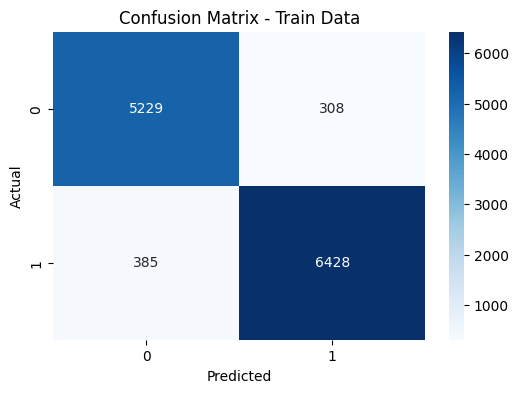

Classification Report - Train Data:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5537
           1       0.95      0.94      0.95      6813

    accuracy                           0.94     12350
   macro avg       0.94      0.94      0.94     12350
weighted avg       0.94      0.94      0.94     12350



In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=105, random_state=42,class_weight={0: 1.0, 1: 3}) #3 best now
rf_model.fit(XX_train, yy_train)  # Train on the training data

# Step 3: Predict on test data (the unseen test set)
y_test_pred = rf_model.predict(XX_test)

# Step 4: Calculate accuracy
accuracy = accuracy_score(yy_test, y_test_pred)
print(f"Accuracy on the Test Set: {accuracy:.4f}")

# Confusion matrix for the test data
cm_test = confusion_matrix(yy_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report for the test data
print("Classification Report - Train Data:")
print(classification_report(yy_test, y_test_pred))


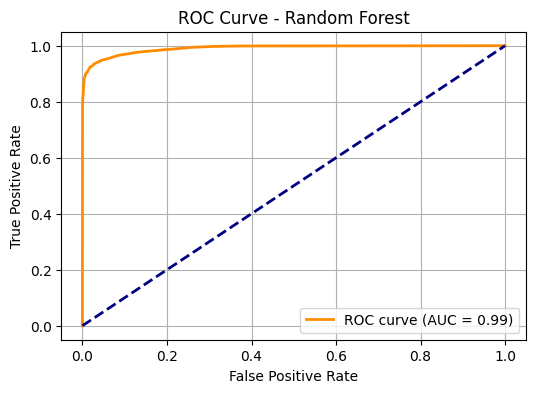

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (class 1)
y_probs = rf_model.predict_proba(XX_test)[:, 1]  # Probability of class 1

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(yy_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid()
plt.show()


**Testing Random Forest**

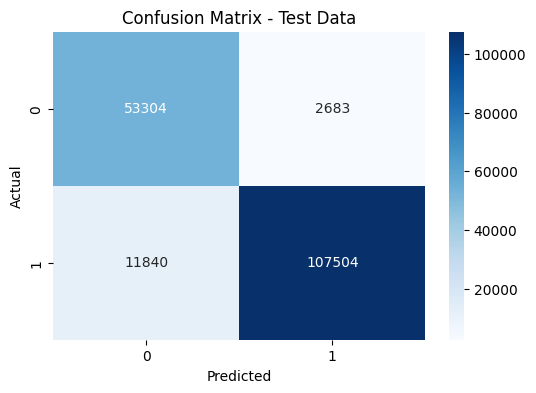

Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88     55987
           1       0.98      0.90      0.94    119344

    accuracy                           0.92    175331
   macro avg       0.90      0.93      0.91    175331
weighted avg       0.93      0.92      0.92    175331

Accuracy on the Test Dataset: 0.9172


In [24]:
y_test_pred = rf_model.predict(X_test_selected)

# Step 3: Confusion matrix for the test dataset
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 4: Classification report for the test dataset
print("Classification Report - Test Data:")
print(classification_report(y_test, y_test_pred))
# Step 5: Accuracy on the test dataset
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on the Test Dataset: {test_accuracy:.4f}")

**XGBoost model train**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:11:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Validation Accuracy: 0.9383805668016194


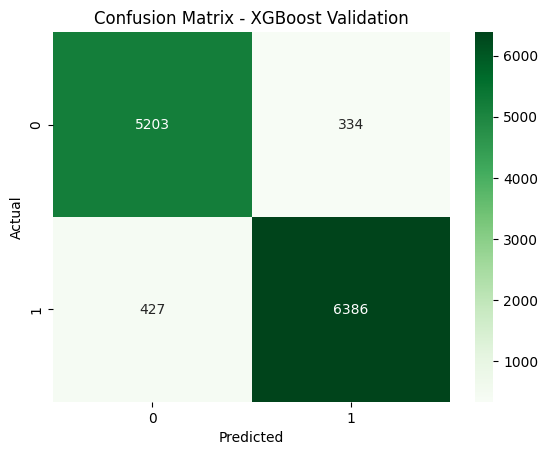

Classification Report - XGBoost Validation:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      5537
           1       0.95      0.94      0.94      6813

    accuracy                           0.94     12350
   macro avg       0.94      0.94      0.94     12350
weighted avg       0.94      0.94      0.94     12350



In [27]:
# ===================== 14. Train XGBoost on Hold-out Set =====================
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=1.6,  # This replaces class_weight
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(XX_train, yy_train)

# Predict on hold-out set
y_pred_xgb_val = xgb_model.predict(XX_test)
print("XGBoost Validation Accuracy:", accuracy_score(yy_test, y_pred_xgb_val))

# Confusion Matrix - Validation
cm_xgb_val = confusion_matrix(yy_test, y_pred_xgb_val)
sns.heatmap(cm_xgb_val, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - XGBoost Validation')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report - Validation
print("Classification Report - XGBoost Validation:")
print(classification_report(yy_test, y_pred_xgb_val))


**XGBoost Model test**

XGBoost Test Accuracy: 0.9191985444673219


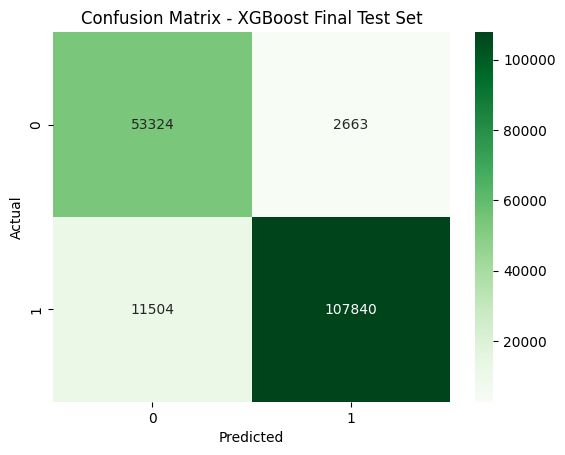

Classification Report - XGBoost Final Test Set:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88     55987
           1       0.98      0.90      0.94    119344

    accuracy                           0.92    175331
   macro avg       0.90      0.93      0.91    175331
weighted avg       0.93      0.92      0.92    175331



In [28]:
# ===================== 15. Evaluate XGBoost on Final Test Set =====================
y_pred_xgb_test = xgb_model.predict(X_test_selected)
print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb_test))

# Confusion Matrix - Final Test
cm_xgb_test = confusion_matrix(y_test, y_pred_xgb_test)
sns.heatmap(cm_xgb_test, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - XGBoost Final Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report - Final Test Set
print("Classification Report - XGBoost Final Test Set:")
print(classification_report(y_test, y_pred_xgb_test))


**KNN training**

KNN Validation Accuracy: 0.9263157894736842


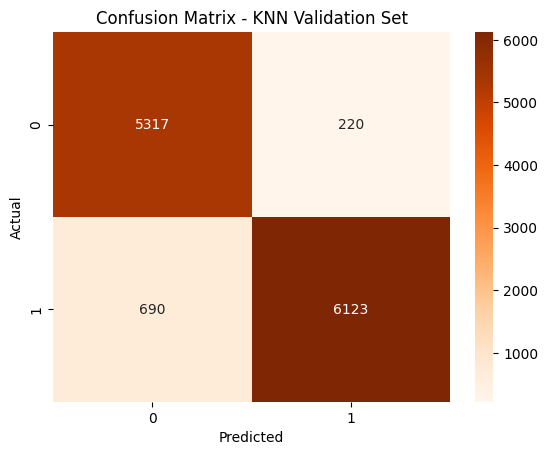

Classification Report - KNN Validation Set:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      5537
           1       0.97      0.90      0.93      6813

    accuracy                           0.93     12350
   macro avg       0.93      0.93      0.93     12350
weighted avg       0.93      0.93      0.93     12350



In [32]:
# ===================== 14. Train K-Nearest Neighbors (KNN) =====================
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=6)  # You can tune n_neighbors later

# Train the model on the training set
knn_model.fit(XX_train, yy_train)

# ===================== 15. Evaluate KNN on Hold-out Validation Set =====================
y_pred_knn_val = knn_model.predict(XX_test)
print("KNN Validation Accuracy:", accuracy_score(yy_test, y_pred_knn_val))

# Confusion Matrix - Validation
cm_knn_val = confusion_matrix(yy_test, y_pred_knn_val)
sns.heatmap(cm_knn_val, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - KNN Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report - KNN Validation Set:")
print(classification_report(yy_test, y_pred_knn_val))


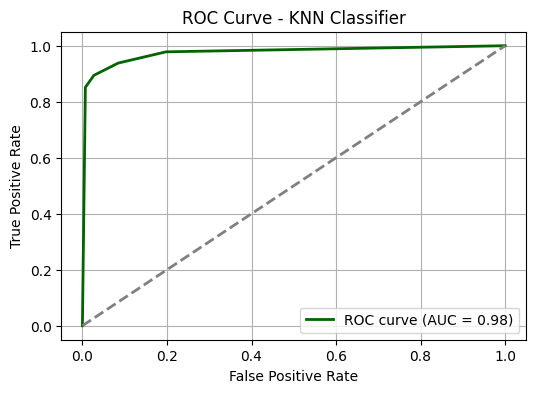

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (class 1)
y_probs_knn = knn_model.predict_proba(XX_test)[:, 1]

# Compute ROC curve and AUC
fpr_knn, tpr_knn, thresholds_knn = roc_curve(yy_test, y_probs_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_knn, tpr_knn, color='darkgreen', lw=2, label=f'ROC curve (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN Classifier')
plt.legend(loc="lower right")
plt.grid()
plt.show()


**KNN testing**

KNN Test Accuracy: 0.8922774197228084


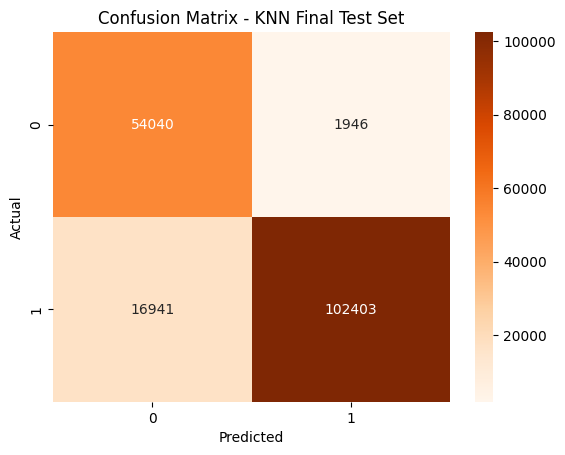

Classification Report - KNN Final Test Set:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85     55986
           1       0.98      0.86      0.92    119344

    accuracy                           0.89    175330
   macro avg       0.87      0.91      0.88    175330
weighted avg       0.91      0.89      0.90    175330



In [33]:
# ===================== 16. Evaluate KNN on Final Test Set =====================
y_pred_knn_test = knn_model.predict(X_test_selected_lasso)
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred_knn_test))

# Confusion Matrix - Final Test
cm_knn_test = confusion_matrix(y_test, y_pred_knn_test)
sns.heatmap(cm_knn_test, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - KNN Final Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report - Final Test Set
print("Classification Report - KNN Final Test Set:")
print(classification_report(y_test, y_pred_knn_test))


**Support Vector Machine (SVM) Training**

SVM Validation Accuracy: 0.897165991902834


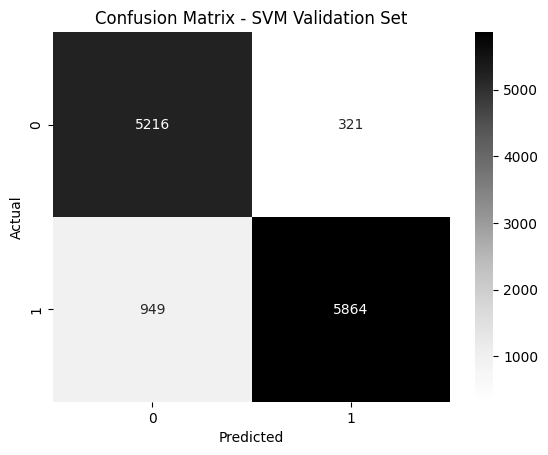

Classification Report - SVM Validation Set:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      5537
           1       0.95      0.86      0.90      6813

    accuracy                           0.90     12350
   macro avg       0.90      0.90      0.90     12350
weighted avg       0.90      0.90      0.90     12350



In [35]:
# ===================== 17. Train Support Vector Machine (SVM) =====================
from sklearn.svm import SVC

# Initialize the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)  # You can tune kernel, C, gamma later

# Train the model on the training set
svm_model.fit(XX_train, yy_train)

# ===================== 18. Evaluate SVM on Hold-out Validation Set =====================
y_pred_svm_val = svm_model.predict(XX_test)
print("SVM Validation Accuracy:", accuracy_score(yy_test, y_pred_svm_val))

# Confusion Matrix - Validation
cm_svm_val = confusion_matrix(yy_test, y_pred_svm_val)
sns.heatmap(cm_svm_val, annot=True, fmt='d', cmap='Greys')
plt.title('Confusion Matrix - SVM Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report - SVM Validation Set:")
print(classification_report(yy_test, y_pred_svm_val))


**SVM test**

SVM Test Accuracy: 0.8809730223008042


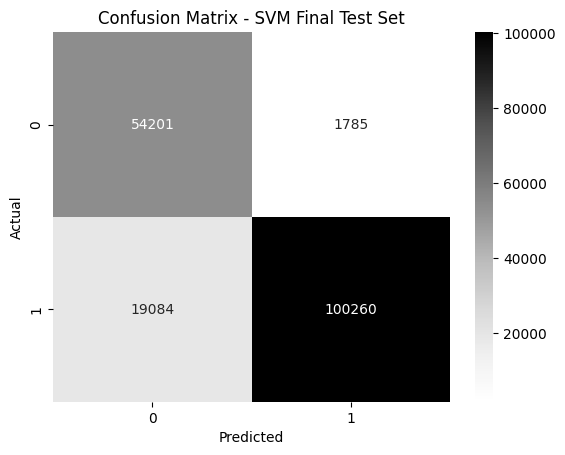

Classification Report - SVM Final Test Set:
              precision    recall  f1-score   support

           0       0.74      0.97      0.84     55986
           1       0.98      0.84      0.91    119344

    accuracy                           0.88    175330
   macro avg       0.86      0.90      0.87    175330
weighted avg       0.90      0.88      0.88    175330



In [36]:
# ===================== 19. Evaluate SVM on Final Test Set =====================
y_pred_svm_test = svm_model.predict(X_test_selected_lasso)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm_test))

# Confusion Matrix - Final Test
cm_svm_test = confusion_matrix(y_test, y_pred_svm_test)
sns.heatmap(cm_svm_test, annot=True, fmt='d', cmap='Greys')
plt.title('Confusion Matrix - SVM Final Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report - Final Test Set
print("Classification Report - SVM Final Test Set:")
print(classification_report(y_test, y_pred_svm_test))


**DeepLearning model (Multilayer Perceptron (MLP))**

Import TensorFlow and Prepare Data

In [37]:
# ===================== 20. Import TensorFlow and Prepare Data =====================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Convert to NumPy arrays for TensorFlow
X_train_nn = XX_train.values
X_val_nn = XX_test.values
y_train_nn = yy_train.values
y_val_nn = yy_test.values

X_test_nn = X_test_selected_lasso.values
y_test_nn = y_test.values


In [38]:
# Assuming you already have X_selected_lasso and y
from sklearn.model_selection import train_test_split

# Re-split consistently
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train_selected_lasso, y_train, test_size=0.15, random_state=42, stratify=y)

# Convert to float32 numpy arrays
X_train_nn = X_train_nn.to_numpy().astype('float32')
X_val_nn = X_val_nn.to_numpy().astype('float32')
y_train_nn = y_train_nn.to_numpy().astype('float32')
y_val_nn = y_val_nn.to_numpy().astype('float32')


Build and Train Deep Learning Model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam



# Build the model
model = Sequential([
    Input(shape=(X_train_nn.shape[1],)),  # define input shape
    Dense(128, activation='relu'),# elave add olundu
    Dropout(0.3), #dropout added
    Dense(64, activation='relu'),
    Dropout(0.3),#added
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_nn, y_train_nn,
                    validation_data=(X_val_nn, y_val_nn),
                    epochs=20, batch_size=64,
                    verbose=1)


Epoch 1/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8409 - loss: 0.3138 - val_accuracy: 0.8981 - val_loss: 0.2013
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9025 - loss: 0.1996 - val_accuracy: 0.9088 - val_loss: 0.1834
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9090 - loss: 0.1861 - val_accuracy: 0.9087 - val_loss: 0.1835
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9114 - loss: 0.1846 - val_accuracy: 0.9116 - val_loss: 0.1786
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9104 - loss: 0.1829 - val_accuracy: 0.9130 - val_loss: 0.1791
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9138 - loss: 0.1792 - val_accuracy: 0.9088 - val_loss: 0.1810
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9127 - loss: 0.1791 - val_accuracy: 0.9119 - val_loss: 0.1775
Epoch 8/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9137 - loss: 0.1790 - 

Performance on testdataset

5480/5480 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9232 - loss: 0.3146
Test Accuracy: 0.9024
Test Loss: 0.2528
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


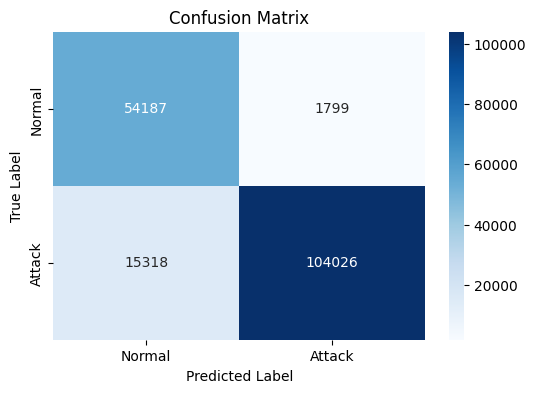


Classification Report:

              precision    recall  f1-score   support

      Normal       0.78      0.97      0.86     55986
      Attack       0.98      0.87      0.92    119344

    accuracy                           0.90    175330
   macro avg       0.88      0.92      0.89    175330
weighted avg       0.92      0.90      0.90    175330



In [40]:
# Evaluate the model on the test data

# Convert test data to float32 numpy arrays
# Convert test data to float32 numpy arrays

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

X_test_nn = X_test_nn.astype('float32')
y_test_nn = y_test_nn.astype('float32')


test_loss, test_accuracy = model.evaluate(X_test_nn, y_test_nn, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")



# Predict probabilities
y_pred_probs = model.predict(X_test_nn)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test_nn, y_pred_classes)

# Plot it
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test_nn, y_pred_classes, target_names=["Normal", "Attack"]))
